# Mammographic Malignancy Predictions Explained - Silvano Ross

Each time this notebook is run different results are explained and may not have accurate markdown explanations associated. 

One may need to re-run this notebook due to the variability in predictions. 

I will be focusing on the `LIME` libraryfor local explanations using surrogate models. 

I will use a public dataset in medical research, which tries to build an ML model to predict whether a tumor is benign or malignant. The complete information of this dataset can be found here: http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/ First let's run the code to load the data. 

In [1]:
# Data Processing Libraries
import pandas as pd
import numpy as np

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

### Pull data from repository

In [2]:
MammURL = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"
ColumnNames = ['BI_RADS', 'Age', 'Shape', 'Margin', 'Density', 'Malignant']
Mamm = pd.read_csv(MammURL, header=None, names=ColumnNames)

### Start feature engineering

In [3]:
# Cast BI_RADS to numeric then impute values for the NaNs that used to be "?"
Mamm.loc[:, "BI_RADS"] = pd.to_numeric(Mamm.loc[:, "BI_RADS"], errors='coerce')
Mamm.loc[Mamm["BI_RADS"].isna(), "BI_RADS"] = Mamm["BI_RADS"].median()
# Limit BI_RADS values to 1, 2, 3, 4, 5
Mamm.loc[Mamm["BI_RADS"] < 1, "BI_RADS"] = 1
Mamm.loc[Mamm["BI_RADS"] > 5, "BI_RADS"] = 5

# Cast Age to numeric then impute values for the NaNs that used to be "?"
Mamm.loc[:, "Age"] = pd.to_numeric(Mamm.loc[:, "Age"], errors='coerce')
Mamm.loc[Mamm["Age"].isna(), "Age"] = Mamm["Age"].median()

# Cast Density to numeric then impute values for the NaNs that used to be "?"
Mamm.loc[:, "Density"] = pd.to_numeric(Mamm.loc[:, "Density"], errors='coerce')
Mamm.loc[Mamm["Density"].isna(), "Density"] = Mamm["Density"].median()

# Simplify Shape and then impute the most common value for "?"
Mamm.loc[ Mamm.loc[:, "Shape"] == "1", "Shape"] = "oval"
Mamm.loc[Mamm.loc[:, "Shape"] == "2", "Shape"] = "oval"
Mamm.loc[Mamm.loc[:, "Shape"] == "3", "Shape"] = "lobu"
Mamm.loc[Mamm.loc[:, "Shape"] == "4", "Shape"] = "irre"
Mamm.loc[Mamm.loc[:, "Shape"] == "?", "Shape"] = Mamm['Shape'].value_counts().idxmax()

# Simplify Margin and then impute the most common value for "?"
Mamm.loc[Mamm.loc[:, "Margin"] == "1", "Margin"] = "circu"
Mamm.loc[Mamm.loc[:, "Margin"] == "2", "Margin"] = "ill_d"
Mamm.loc[Mamm.loc[:, "Margin"] == "3", "Margin"] = "ill_d"
Mamm.loc[Mamm.loc[:, "Margin"] == "4", "Margin"] = "ill_d"
Mamm.loc[Mamm.loc[:, "Margin"] == "5", "Margin"] = "spicu"
Mamm.loc[Mamm.loc[:, "Margin"] == "?", "Margin"] = Mamm['Margin'].value_counts().idxmax()

# One-hot encode the categorical columns, Shape and Margin
CategoricalColumns = ["Shape", "Margin"]
onehot = OneHotEncoder(sparse = False, handle_unknown = "ignore")
onehot.fit(Mamm[CategoricalColumns])
onehot_col_names = onehot.get_feature_names_out(CategoricalColumns)
MammCategories = pd.DataFrame(onehot.transform(Mamm[CategoricalColumns]), columns = onehot_col_names)
MammCategories = MammCategories.astype(int)

# Combine the one-hot encoded columns with the numerical columns
MammComplete = pd.concat([Mamm.drop(columns = ['Shape', "Margin"]), MammCategories], axis = 1)

# Split the data into input variables (X) and target outcome (y)
X = MammComplete.drop(columns = "Malignant")
y = MammComplete["Malignant"]
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# # Normalize data for dimension size-sensitive algorithms, like SVM
# normalizer = sklearn.preprocessing.StandardScaler()
# normalizer.fit(X_train)
# X_train = pd.DataFrame(normalizer.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(normalizer.transform(X_test), columns=X_train.columns)

# Present the processed data
print(X_test.head())

    BI_RADS   Age Density  Shape_irre  Shape_lobu  Shape_oval  Margin_circu   
611     5.0  59.0     3.0           1           0           0             0  \
358     5.0  55.0     3.0           1           0           0             0   
179     5.0  49.0     3.0           1           0           0             0   
294     4.0  62.0     3.0           0           0           1             0   
509     5.0  75.0     3.0           1           0           0             0   

     Margin_ill_d  Margin_spicu  
611             0             1  
358             1             0  
179             1             0  
294             1             0  
509             0             1  


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Engineer numeric and categorical columns for use in the LimeTabularExplainer

Assign a list of indices of categorical features that will be used in `LimeTabularExplainer` to `categorical_features`.  For instance, since `Shape_irre` is a binary column and `Shape_irre` is the 4th column, `categorical_features` should contain the index 3.  See https://lime-ml.readthedocs.io/en/latest/lime.html and search for `LimeTabularExplainer` and search the parameters list.

In [4]:
list(X_train.columns)

['BI_RADS',
 'Age',
 'Density',
 'Shape_irre',
 'Shape_lobu',
 'Shape_oval',
 'Margin_circu',
 'Margin_ill_d',
 'Margin_spicu']

In [5]:
# create category index
cat_index = [3, 4, 5, 6, 7, 8]
col_names = list(X_train.columns)
cat_map = dict(zip(cat_index, X_train.iloc[:, 3:].columns))
cat_map

{3: 'Shape_irre',
 4: 'Shape_lobu',
 5: 'Shape_oval',
 6: 'Margin_circu',
 7: 'Margin_ill_d',
 8: 'Margin_spicu'}

### Instantiate Lime Explainer taking care to denote categorical columns

In [6]:
!pip install lime

In [7]:
# import explainer
from lime.lime_tabular import LimeTabularExplainer

# set explainer's parameters
explainer = LimeTabularExplainer(
                        training_data = X_train.values,
                        class_names = [False, True],
                        feature_names = list(X_train.columns),
                        categorical_features=[3,4,5,6,7,8], 
                        random_state=42
                        )

### Create two models to later explain individual prediction instances.

#### First create RandomForestClassifier and get metrics

In [8]:
# import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# call classifier
rf = RandomForestClassifier(n_estimators=20,
                            max_features=0.25,
                            criterion="entropy",
                            max_depth=5,
                            min_samples_leaf=10,
                            n_jobs=10,
                            random_state=42,
                            verbose=1)

# train on training data
rf.fit(X_train, y_train)

# make predictions
pred_rf = (rf.predict_proba(X_test)[:,1] >= 0.5)

# create accuracy score
acc_rf = accuracy_score(y_test, pred_rf)

print(f"The accuracy of the Random Forest Classifier is : {acc_rf:.3f}")

The accuracy of the Random Forest Classifier is : 0.839


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished


<Axes: xlabel='importance', ylabel='feature'>

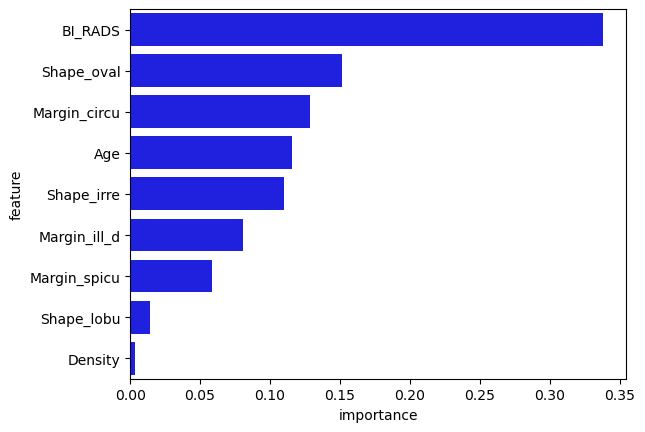

In [9]:
# show top 5 features
import seaborn as sns
feature_names = list(X_train.columns)
df_var_imp = pd.DataFrame({"feature": feature_names, 
                           "importance": rf.feature_importances_})
df_var_imp.sort_values(by="importance", ascending=False, inplace=True)

sns.barplot(x="importance", y="feature", data=df_var_imp.head(15), color="blue")

### Create Mulit-Layer Perceptrion neural net and get metrics

In [10]:
# import Mulit Layer Perceptron model
from sklearn.neural_network import MLPClassifier

# call classifier
mlp_class = MLPClassifier(max_iter=300,
                          early_stopping=True,
                          n_iter_no_change = 100,
                          tol=0.0001,
                          random_state=42)

# fit to data
mlp_class.fit(X_train, y_train)

# make probability predictions with rounding
pred_mlp = (mlp_class.predict_proba(X_test)[:,1] >=0.5)

# create accuracy score 
acc_mlp = accuracy_score(y_test, pred_mlp)

print(f"The accuracy score of the MLP Classifer is: {acc_mlp:.3f}")

The accuracy score of the MLP Classifer is: 0.803


### Find instances of interest to explain with LIME Tabular Explainer

Find a row where the Random Forest Classifier predicts opposite of the Neural Net.

Find a row where the difference in predicted probailities is greater than 0.4

In [11]:
# create preds
pred_rf = rf.predict_proba(X_test)[:,1]
pred_mlp = mlp_class.predict_proba(X_test)[:,1]
pred_rf[:5] # review

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.1s finished


array([0.86383099, 0.82434362, 0.80690665, 0.22062361, 0.89880141])

In [12]:
# loop through list and find when prob is greater less than 3 for rf and greater than 7 for mlp
rf_indx = []
mlp_indx = []
for idx in range(0, len(y_test)):
    if pred_rf[idx] <= 0.3:
        rf_indx.append(idx)
    if pred_mlp[idx] >= 0.7:
            mlp_indx.append(idx)
print(f"RF indices/rows meeting criteria: {rf_indx[:5]}")
print(f"MLP indices/rows meeting criteria: {mlp_indx[:5]}")


RF indices/rows meeting criteria: [3, 6, 9, 13, 15]
MLP indices/rows meeting criteria: [0, 1, 2, 4, 5]


In [13]:
rf_indx[0]

3

In [14]:
#look for instances when pp diff is 0.4 or greater
diff = []
for idx in range(0, len(y_test)):
    if np.abs(pred_rf[idx] - pred_mlp[idx]) >= 0.4:# 0.3 - 0.7
        diff.append(idx)       
diff

[27]

In [15]:
# look at RF pp < 0.3 compared to ground truth at index 1
print(f"The ground truth at row {rf_indx[0]} is: {y_test.iloc[rf_indx[0]]} \nThe RF Classifier predicted probability: {pred_rf[rf_indx[0]]:.3f} \nThe MLP pp: {pred_mlp[rf_indx[0]]:.3f} ")

The ground truth at row 3 is: 0 
The RF Classifier predicted probability: 0.221 
The MLP pp: 0.344 


In [16]:
# look at MLP pp > 0.7 compared to ground truth
print(f"The ground truth at row {mlp_indx[0]} is: {y_test.iloc[mlp_indx[0]]} \nThe MLP pp: {pred_mlp[mlp_indx[0]]:.3f}\nThe RF Classifier predicted probability: {pred_rf[mlp_indx[0]]:.3f} ")

The ground truth at row 0 is: 1 
The MLP pp: 0.861
The RF Classifier predicted probability: 0.864 


In [17]:
# look at instance when they are 0.4 apart
try:
    print(f"The ground truth at row {diff[-1]} is: {y_test.iloc[diff[-1]]} \nThe MLP pp: {pred_mlp[diff[-1]]:.3f}\nThe RF Classifier predicted probability: {pred_rf[diff[-1]]:.3f} ")
except Exception as e:
    print("There were no instances when the to models were 0.4 apart")

The ground truth at row 27 is: 0 
The MLP pp: 0.239
The RF Classifier predicted probability: 0.694 


I was not able to find a point where the two algorithms were discrepant to that degree. I will look for a less severe discrepancy where the two models would call different predictions with a threshold of 0.5.

In [18]:
# create idx list
try:
    indx = []
    for row in range(0, len(y_test)):
        if pred_rf[row] < 0.47 and pred_mlp[row] > 0.6:
            indx.append(row)
    indx[0]
except:
    pass

In [19]:
# Hopefully there is an indx where the two models would be discrepant with a threshold of 0.5
try:
    if len(indx) > 0:
        print(f"The ground truth at row {indx[0]} is: {y_test.iloc[indx[0]]} \nThe MLP pp: {pred_mlp[indx[0]]:.3f}\nThe RF Classifier predicted probability: {pred_rf[indx[0]]:.3f}")
    else:
        print("There were no instances where the two models made severely discrepant calls, RERUN the entire notebook to see if one gets generated.")
except:
    pass

The ground truth at row 120 is: 1 
The MLP pp: 0.619
The RF Classifier predicted probability: 0.441


Use the `explain_instance` function of `explainer` to create an explainer for the **random forest** classifier's prediction of the chosen row.  Name this explainer `rf_exp`.
- Assign the values in the chosen row of X_test to the `data_row` argument
- Assign the probability predictor (`predict_proba`) of the random forest to the `predict_fn` argument

[5 point]

In [20]:
# show row for discrepant instance
try:
    display(X_test.iloc[diff[0]])
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

BI_RADS          5.0
Age             42.0
Density          3.0
Shape_irre         0
Shape_lobu         0
Shape_oval         1
Margin_circu       0
Margin_ill_d       1
Margin_spicu       0
Name: 7, dtype: object

In [21]:
# explain instance for RF with top 5 features
try:
    rf_exp = explainer.explain_instance(X_train.iloc[diff[0], :].values, predict_fn=rf.predict_proba, num_features=5)
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.1s finished


Use the `explain_instance` function of `explainer` to pass an instance (your chosen row) to the explainer for the **neural net** classifier's prediction of the chosen row.  Name this explainer `nn_exp`.
- Assign the the chosen row of values from the test data inputs to the `data_row` argument
- Assign the probability predictor (`predict_proba`) of the neural net to the `predict_fn` argument

[5 point]

In [22]:
# NN explainer
try:
    nn_exp = explainer.explain_instance(X_train.iloc[diff[0], :].values, predict_fn=mlp_class.predict_proba, num_features=5)
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Present the explantion for the chosen instance by using the method `as_pyplot_figure` for the random forest (`rf_exp`).  

[5 point]

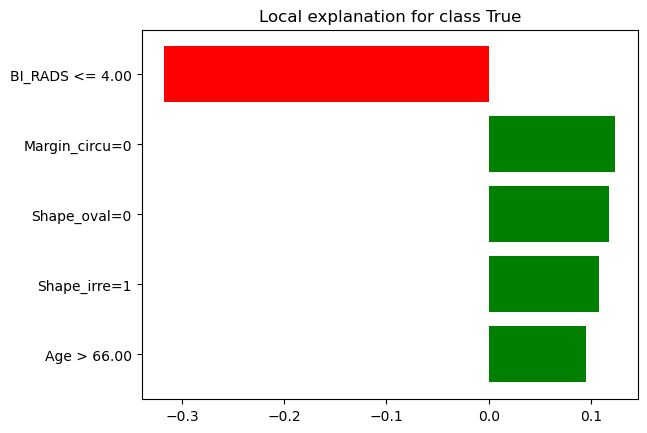

In [23]:
# present rf_exp
try:
    rf_exp.as_pyplot_figure()
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

Present the explantion for the chosen instance by using the method `as_list()` for the random forest (`rf_exp`).  Present the coefficient of determination (R2) for the `score` as an accuracy measure for the explanation.

[5 point]

In [24]:
# rf_exp as list
try:
    display(rf_exp.as_list())
    print(f"The feature that plays the biggest role in this prediction instance is {rf_exp.as_list()[0][0]}")
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

[('BI_RADS <= 4.00', -0.31722259317821255),
 ('Margin_circu=0', 0.12362591758773937),
 ('Shape_oval=0', 0.11724634555439932),
 ('Shape_irre=1', 0.1079789715869641),
 ('Age > 66.00', 0.09538035378600064)]

The feature that plays the biggest role in this prediction instance is BI_RADS <= 4.00


In [25]:
# show R^2
try:
    from sklearn.metrics import r2_score
    R_rf = r2_score(y_test, (rf.predict_proba(X_test)[:,1] >= 0.5))
    print(f"R^2 for RFC vs Ground Truth: {R_rf}")
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

R^2 for RFC vs Ground Truth: 0.35735767991407097


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished


- Present the explantion for the chosen instance by using the method `as_pyplot_figure` for the neural net (`nn_exp`).  

[5 point]

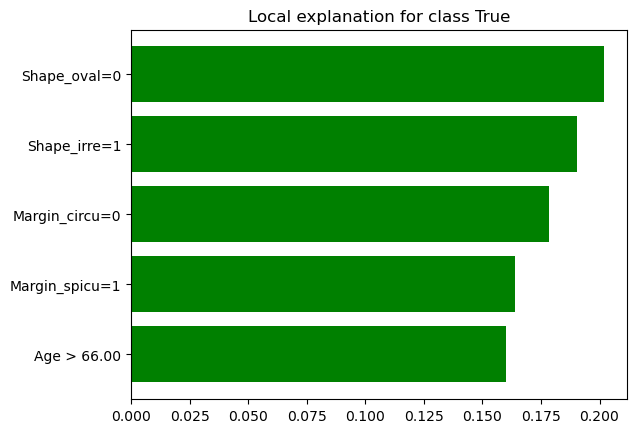

In [26]:
# NN as plot
try:
    nn_exp.as_pyplot_figure()
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

- Present the explantion for the chosen instance by using the method `as_list()` for the neural net (`nn_exp`).  Present the coefficient of determination (R2) for the `score` as an accuracy measure for the explanation.

[5 point]

In [27]:
# nn as list
try:
    display(nn_exp.as_list())
    print()
    print(f"The feature that plays the biggest role in this NN prediction instance is {nn_exp.as_list()[0][0]}")
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

[('Shape_oval=0', 0.20173563815793283),
 ('Shape_irre=1', 0.1905350990925512),
 ('Margin_circu=0', 0.17846925633485164),
 ('Margin_spicu=1', 0.1639998180138626),
 ('Age > 66.00', 0.1599027915497704)]


The feature that plays the biggest role in this NN prediction instance is Shape_oval=0


In [28]:
# nn r2
try:
    R_nn = r2_score(y_test, mlp_class.predict(X_test))
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

In [29]:
try:
    print(f"R^2 for NN: {R_nn}")
except:
    print("RERUN notebook, there were no instances when the two models were severely discrepant")

R^2 for NN: 0.21224489795918378


In [30]:
# Use lime to automatically calculate R2 for both models compared to the internal linear regression algorithm

print(f" The R2 for the RF is: {rf_exp.score:.3f} \nThe R2 for the MLP is: {nn_exp.score:.3f}")

 The R2 for the RF is: 0.857 
The R2 for the MLP is: 0.851


Both of the models can be explained with the 

In [31]:
pred_mlp_round = np.array(pd.Series(pred_mlp).apply(lambda x: 1 if x >= 0.5 else 0))
pred_rf_round = np.array(pd.Series(pred_rf).apply(lambda x: 1 if x >= 0.5 else 0))


In [32]:
# final R^2 of the black box MLP vs glass box RFC
try:
    r2 = r2_score(y_true=pred_mlp_round, y_pred=pred_rf_round)
    print(f"R^2 comparing the NN predictions to RFC predictions is: {r2:.3f}")
except:
     print("RERUN notebook, there were no instances when the two models were severely discrepant")

R^2 comparing the NN predictions to RFC predictions is: 0.523


#### Identify the similarities and differences between the explanations for the neural net and the random forest on your chosen instance

##### When I ran it the first time this was what I got.

**Similarities**

- Both models have similar R^2 scores that tell us roughly 85% of the variation in the outcome is not explained by our model. And both models have a semi-high accuracy between ~70-80%. Both models have similar top features: BI-RADS between 4-5, Margin circumscribed - false, Shape oval - false and irregular - true. The two sets of predictions are somewhat explained by eachother having a postivie R2 value, but there is still a lot of variability between tht two models.

**Differences**

- The two models have one top feature that differs from each other - RF - Margin ill defined - false and NN - Margin spiculated - true for this instance of a prediction. The two models rank features much differently for this instance as well. The Random Forest Classifier nearly put nearly half of the importance on BI-RADS - 4-5 feature, (1 means benign and 5 means suggestive of malignancy). The neural net was much more even in how it ranked feature importance for the instance investigated and put roughly 15-25% on Margin circumscribed - false and spiculated - true, and Shape oval - false or irregular - true, leaving BI-RADS between 4-5 having a 7% rankning in the investigated prediction. 

**Interesting Points**

- I investigated the feature_importance feature native to the RF Classifier and Age was suggested as a top feature for predicting malignancy. To generalize, the feature_importance_ method creates a general feature importance list. But going deeper, each prediction has its own specific feature importance ranking.  
- The Lime explainer shows that a higher percentage of the prediction for the Random Forest Classifier can be explained with a simpler model vs a lower percentage for the Multi Layer Perceptron model.